# Assignment 2a
## Numerical Optimization & Large Scale Linear Algebra
### Professor: P. Vassalos

### Stratos Gounidellis, DS3517005

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.linalg import kron
import matplotlib.pyplot as plt
% matplotlib inline


## Data Loading

In [2]:
# read the given data. Matrix A, followed by B, followed by G. 
# Each matrix is of size 256x256. 
# The entries are given in row order, 4 per line.
matrix = np.fromfile("data", sep=" ")
A = matrix[0:256**2].reshape(256, 256)
B = matrix[256**2:2*(256**2)].reshape(256, 256)
G = matrix[2*(256**2):]


## Methods' Definitions

In [3]:
# method to compute the SVD analysis
# of a given array
def svd_transform(X):
    U, s, Vh = linalg.svd(np.asarray(X), check_finite=False)
    return U, s, Vh

# method to compute the left singular vector of a
# matrix given that the matrix can be expressed as
# the Kronecker product of two smaller matrices
def compute_ui(col_Ua, Ua, col_Ub, Ub):
    return np.kron(Ua[:, col_Ua], Ub[:, col_Ub]).T

# method to compute the right singular vector of a
# matrix given that the matrix can be expressed as
# the Kronecker product of two smaller matrices
def compute_vi(col_Va, Va, col_Vb, Vb):
    return np.kron(Va.T[:, col_Va], Vb.T[:, col_Vb])

# method to compute the singular values of a
# matrix given that the matrix can be expressed as
# the Kronecker product of two smaller matrices
def compute_s(sA, sB):
    return np.kron(sA, sB)

# method to compute which column of the 
# two matrices should be used to calculate
# the singular vector of another matrix as the
# kronecker product of their respective kronecker 
# products
def compute_columns(column, shape):
    col_a = column // shape
    col_b = column % shape
    return col_a, col_b

# method to truncate the singular value 
# decomposition (SVD)
def truncated_svd(p, G, A_svd, B_svd):
    # compute the singular values based on the
    # properties of the Kronecker product
    s = compute_s(A_svd[1], B_svd[1])
    # compute and store the indices of the sorted
    # singular values
    sort_list = s.argsort()[-p:][::-1]
    shape = A_svd[0].shape[0]
    f = np.zeros((1, 256**2))
    for i in range(p):
        col_a, col_b = compute_columns(sort_list[i], shape)
        # apply the following formula to reconstruct 
        # the true original image F
        dot_p = np.dot(compute_ui(col_a, A_svd[0],
                                  col_b, B_svd[0]), G) / s[sort_list[i]]
        out = np.outer(dot_p, compute_vi(col_a, A_svd[2], col_b, B_svd[2]))
        f += out
    # return the reconstructed image F
    return f

# method to determine the Tikhonov solution. In that approach
# we use all the basis vectors.
def tikhonov_regularization(p, G, A_svd, B_svd, alpha):
    # compute the singular values based on the
    # properties of the Kronecker product
    s = compute_s(A_svd[1], B_svd[1])
    f = np.zeros((1, 256**2))
    shape = A_svd[0].shape[0]
    for i in range(p):
        col_a, col_b = compute_columns(i, shape)
        # apply the following formula to reconstruct 
        # the true original image F
        dot_p = np.dot(compute_ui(col_a, A_svd[0], col_b, B_svd[0]), G)
        out = np.outer(dot_p, compute_vi(col_a, A_svd[2], col_b, B_svd[2]))
        out = np.outer(s[i], out) / (s[i]**2 + alpha**2)
        f += out
    # return the reconstructed image F
    return f

# method to convert an array to image,
# plot the number of basis vectors
# and the reconstructed image
def to_image(images_list):
    counter = 0
    basis_vectors = 500
    while counter < len(images_list):
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 4), ncols=3)
        im = ax1.imshow(images_list[counter].reshape(256, 256))
        ax1.set_title("Number of basis vectors: " +
                      str(basis_vectors*(counter + 1)))

        counter += 1
        if counter < len(images_list):
            im = ax2.imshow(images_list[counter].reshape(256, 256))
            ax2.set_title("Number of basis vectors: " +
                          str(basis_vectors*(counter + 1)))

        counter += 1
        if counter < len(images_list):
            im = ax3.imshow(images_list[counter].reshape(256, 256))
            ax3.set_title("Number of basis vectors: " +
                          str(basis_vectors*(counter + 1)))
        counter += 1

# method to convert an array to image,
# plot the value of the alpha parameter
# and the reconstructed image
def to_image_reg(images_list, alphas):
    counter = 0
    while counter < len(images_list):
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
        im = ax1.imshow(images_list[counter].reshape(256, 256))
        ax1.set_title("Alpha parameter: " + str(alphas[counter]))

        counter += 1
        if counter < len(images_list):
            im = ax2.imshow(images_list[counter].reshape(256, 256))
            ax2.set_title("Alpha parameter: " + str(alphas[counter]))

        counter += 1
        if counter < len(images_list):
            im = ax3.imshow(images_list[counter].reshape(256, 256))
            ax3.set_title("Alpha parameter: " + str(alphas[counter]))
        counter += 1


In [4]:
A_svd = svd_transform(A)
B_svd = svd_transform(B)


## Truncated SVD

In [5]:
list_trunc_f = []
basis_vectors = np.arange(500, 11000, 500)
for basis_vector in basis_vectors:
    list_trunc_f.append(truncated_svd(basis_vector, G, A_svd, B_svd))

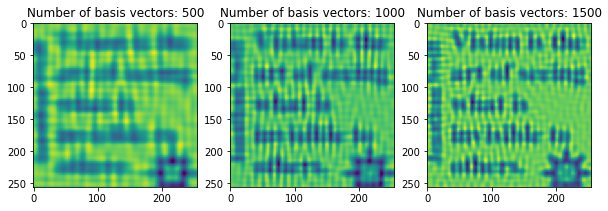

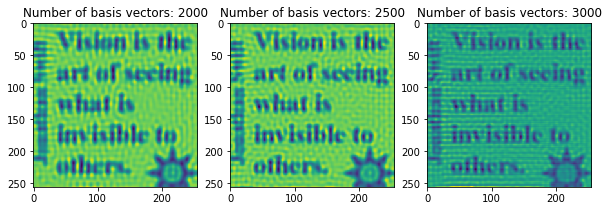

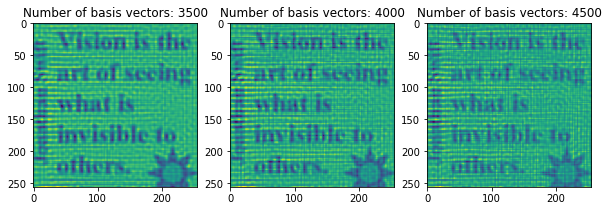

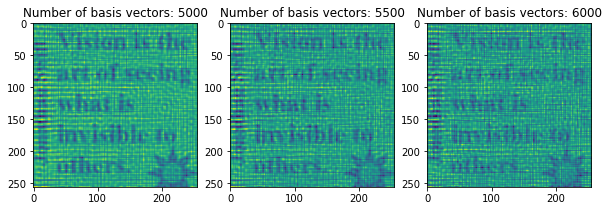

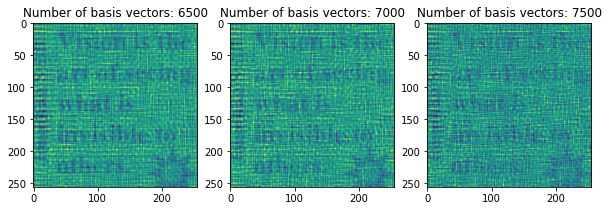

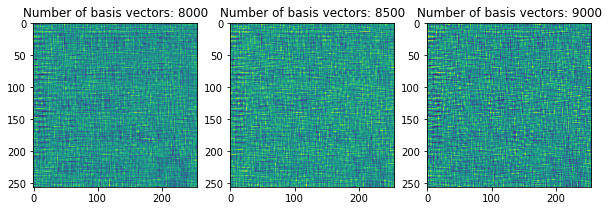

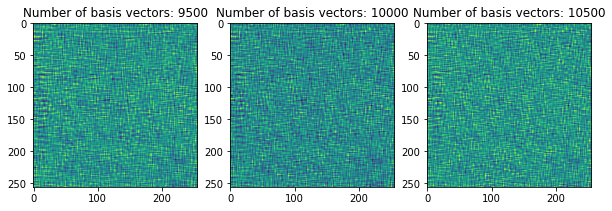

In [8]:
# We observe that the clearest image is
# presented for 3000 or 3500 basis vectors.
# Obviously, the text written in the image is
# "Vision is the art of seeing what is invisible
# to others."
to_image(list_trunc_f)

## Tikhonov regularization

In [6]:
list_reg = []
alphas = np.logspace(-5, 0, 30)
for alpha in alphas:
    list_reg.append(tikhonov_regularization(256**2, G, A_svd, B_svd, alpha))


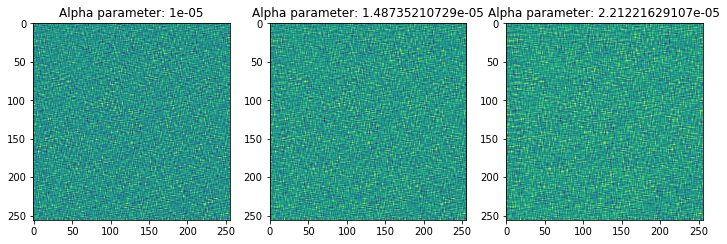

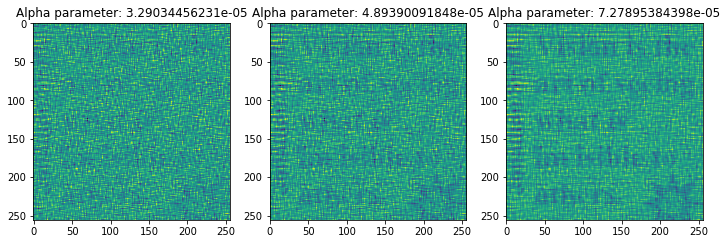

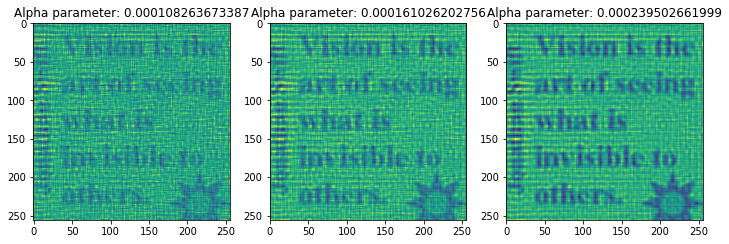

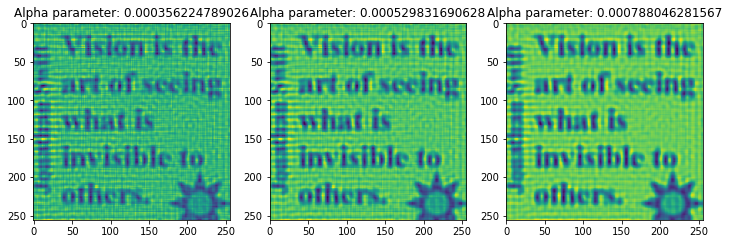

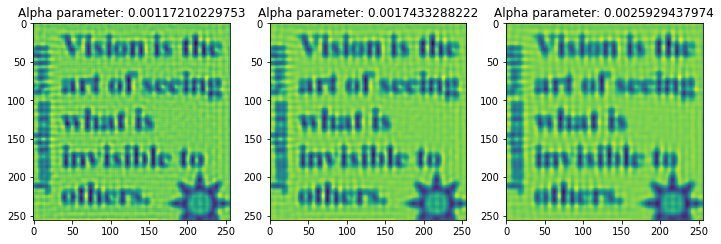

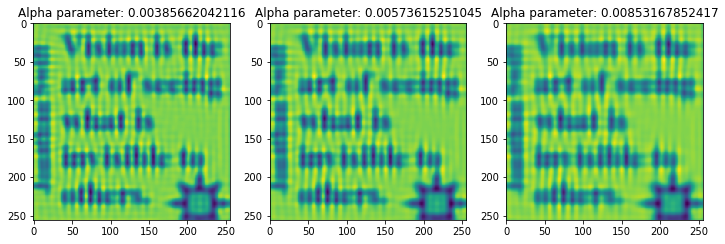

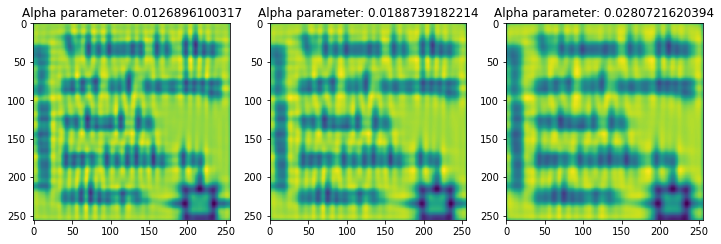

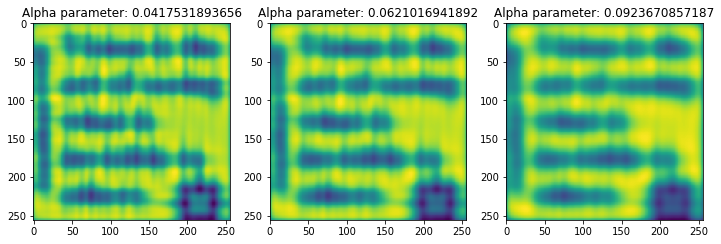

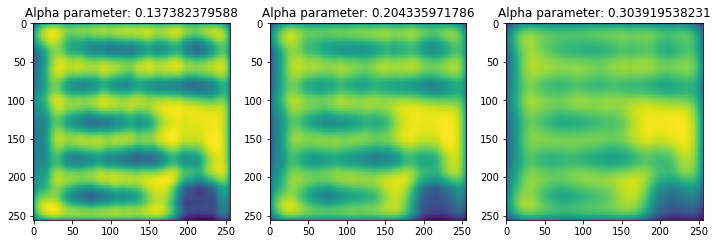

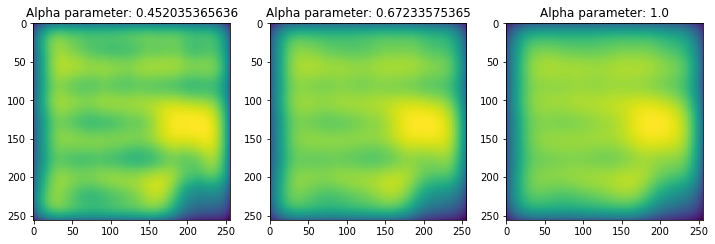

In [7]:
# We observe that the clearest image is
# presented for alpha between 0.00035 and 0.0078.
# Obviously, the text written in the image is
# "Vision is the art of seeing what is invisible
# to others."
to_image_reg(list_reg, alphas)